# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

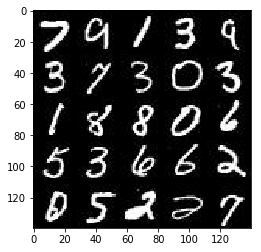

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

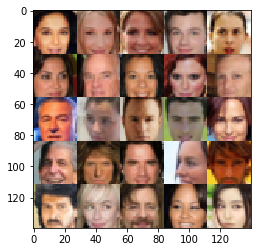

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "lr")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        relu1 = leaky_relu(x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, 2, 'same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, 2, 'same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        # 4*4*256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 4*4*256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, 1, 'valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*64
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
        # 28*28*out_channel_dim
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*alpha))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)      
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.6884... Generator Loss: 13.0631
Epoch 1/2... Batch 20... Discriminator Loss: 0.7890... Generator Loss: 9.3589
Epoch 1/2... Batch 30... Discriminator Loss: 0.6746... Generator Loss: 4.7490
Epoch 1/2... Batch 40... Discriminator Loss: 0.6769... Generator Loss: 2.8660
Epoch 1/2... Batch 50... Discriminator Loss: 0.4415... Generator Loss: 3.1297
Epoch 1/2... Batch 60... Discriminator Loss: 1.7051... Generator Loss: 0.4770
Epoch 1/2... Batch 70... Discriminator Loss: 1.4092... Generator Loss: 0.7732
Epoch 1/2... Batch 80... Discriminator Loss: 0.5339... Generator Loss: 2.3721
Epoch 1/2... Batch 90... Discriminator Loss: 0.4086... Generator Loss: 3.4957
Epoch 1/2... Batch 100... Discriminator Loss: 0.8080... Generator Loss: 1.7015


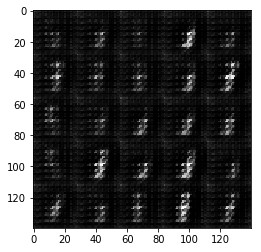

Epoch 1/2... Batch 110... Discriminator Loss: 0.4652... Generator Loss: 3.5749
Epoch 1/2... Batch 120... Discriminator Loss: 0.6447... Generator Loss: 3.1151
Epoch 1/2... Batch 130... Discriminator Loss: 0.6100... Generator Loss: 3.8646
Epoch 1/2... Batch 140... Discriminator Loss: 0.7861... Generator Loss: 1.4433
Epoch 1/2... Batch 150... Discriminator Loss: 0.5337... Generator Loss: 2.1085
Epoch 1/2... Batch 160... Discriminator Loss: 0.9275... Generator Loss: 2.3541
Epoch 1/2... Batch 170... Discriminator Loss: 0.7187... Generator Loss: 2.3538
Epoch 1/2... Batch 180... Discriminator Loss: 1.0492... Generator Loss: 3.9397
Epoch 1/2... Batch 190... Discriminator Loss: 0.8635... Generator Loss: 3.4356
Epoch 1/2... Batch 200... Discriminator Loss: 0.7500... Generator Loss: 2.6749


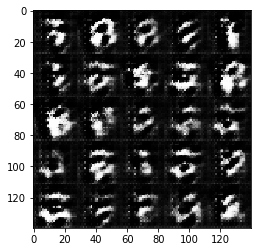

Epoch 1/2... Batch 210... Discriminator Loss: 0.8329... Generator Loss: 1.3237
Epoch 1/2... Batch 220... Discriminator Loss: 0.8019... Generator Loss: 2.4910
Epoch 1/2... Batch 230... Discriminator Loss: 1.0532... Generator Loss: 0.9359
Epoch 1/2... Batch 240... Discriminator Loss: 0.7850... Generator Loss: 1.8939
Epoch 1/2... Batch 250... Discriminator Loss: 0.7578... Generator Loss: 1.9152
Epoch 1/2... Batch 260... Discriminator Loss: 0.8917... Generator Loss: 2.3334
Epoch 1/2... Batch 270... Discriminator Loss: 1.4286... Generator Loss: 3.3369
Epoch 1/2... Batch 280... Discriminator Loss: 1.2122... Generator Loss: 0.8157
Epoch 1/2... Batch 290... Discriminator Loss: 0.8888... Generator Loss: 2.1574
Epoch 1/2... Batch 300... Discriminator Loss: 0.9175... Generator Loss: 1.1156


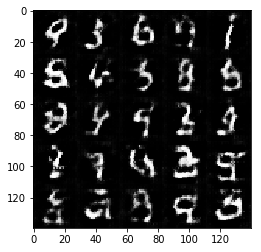

Epoch 1/2... Batch 310... Discriminator Loss: 1.4003... Generator Loss: 3.3945
Epoch 1/2... Batch 320... Discriminator Loss: 1.0163... Generator Loss: 2.0955
Epoch 1/2... Batch 330... Discriminator Loss: 1.0817... Generator Loss: 0.8303
Epoch 1/2... Batch 340... Discriminator Loss: 1.0093... Generator Loss: 0.9251
Epoch 1/2... Batch 350... Discriminator Loss: 0.9165... Generator Loss: 1.1618
Epoch 1/2... Batch 360... Discriminator Loss: 0.9265... Generator Loss: 1.2023
Epoch 1/2... Batch 370... Discriminator Loss: 0.8943... Generator Loss: 1.7996
Epoch 1/2... Batch 380... Discriminator Loss: 0.9456... Generator Loss: 1.3319
Epoch 1/2... Batch 390... Discriminator Loss: 1.0187... Generator Loss: 0.9591
Epoch 1/2... Batch 400... Discriminator Loss: 1.2469... Generator Loss: 0.6334


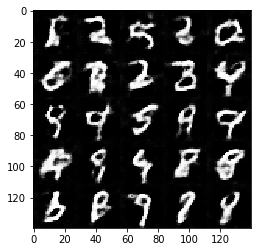

Epoch 1/2... Batch 410... Discriminator Loss: 0.9474... Generator Loss: 1.4054
Epoch 1/2... Batch 420... Discriminator Loss: 1.0868... Generator Loss: 0.8070
Epoch 1/2... Batch 430... Discriminator Loss: 1.4368... Generator Loss: 0.5176
Epoch 1/2... Batch 440... Discriminator Loss: 1.1822... Generator Loss: 0.6660
Epoch 1/2... Batch 450... Discriminator Loss: 0.9585... Generator Loss: 2.1416
Epoch 1/2... Batch 460... Discriminator Loss: 1.2713... Generator Loss: 2.8206
Epoch 2/2... Batch 10... Discriminator Loss: 0.9060... Generator Loss: 1.7590
Epoch 2/2... Batch 20... Discriminator Loss: 1.1041... Generator Loss: 0.8181
Epoch 2/2... Batch 30... Discriminator Loss: 1.2838... Generator Loss: 0.5793
Epoch 2/2... Batch 40... Discriminator Loss: 0.9210... Generator Loss: 1.5234
Epoch 2/2... Batch 50... Discriminator Loss: 2.0469... Generator Loss: 3.4095
Epoch 2/2... Batch 60... Discriminator Loss: 0.9335... Generator Loss: 1.5335
Epoch 2/2... Batch 70... Discriminator Loss: 0.8905... Gen

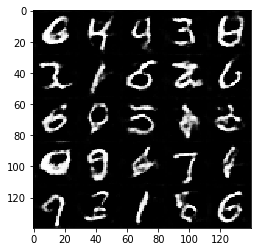

Epoch 2/2... Batch 110... Discriminator Loss: 1.1323... Generator Loss: 0.8681
Epoch 2/2... Batch 120... Discriminator Loss: 0.9419... Generator Loss: 1.1819
Epoch 2/2... Batch 130... Discriminator Loss: 1.0109... Generator Loss: 1.1664
Epoch 2/2... Batch 140... Discriminator Loss: 1.2179... Generator Loss: 2.3359
Epoch 2/2... Batch 150... Discriminator Loss: 1.0729... Generator Loss: 0.8014
Epoch 2/2... Batch 160... Discriminator Loss: 1.0603... Generator Loss: 1.9468
Epoch 2/2... Batch 170... Discriminator Loss: 1.1318... Generator Loss: 0.7332
Epoch 2/2... Batch 180... Discriminator Loss: 1.6528... Generator Loss: 0.3967
Epoch 2/2... Batch 190... Discriminator Loss: 1.1963... Generator Loss: 0.9570
Epoch 2/2... Batch 200... Discriminator Loss: 1.5113... Generator Loss: 2.2764


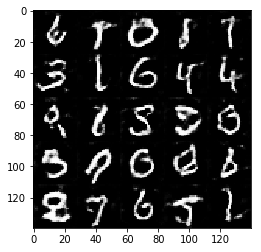

Epoch 2/2... Batch 210... Discriminator Loss: 1.0847... Generator Loss: 1.1745
Epoch 2/2... Batch 220... Discriminator Loss: 1.0267... Generator Loss: 0.9300
Epoch 2/2... Batch 230... Discriminator Loss: 1.7874... Generator Loss: 0.3649
Epoch 2/2... Batch 240... Discriminator Loss: 0.9481... Generator Loss: 1.4019
Epoch 2/2... Batch 250... Discriminator Loss: 0.9809... Generator Loss: 1.3941
Epoch 2/2... Batch 260... Discriminator Loss: 0.9225... Generator Loss: 1.1577
Epoch 2/2... Batch 270... Discriminator Loss: 0.9313... Generator Loss: 1.3027
Epoch 2/2... Batch 280... Discriminator Loss: 2.0780... Generator Loss: 2.9638
Epoch 2/2... Batch 290... Discriminator Loss: 1.2412... Generator Loss: 0.6872
Epoch 2/2... Batch 300... Discriminator Loss: 0.9960... Generator Loss: 1.1111


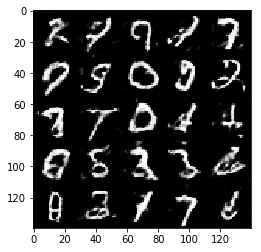

Epoch 2/2... Batch 310... Discriminator Loss: 1.2129... Generator Loss: 0.6933
Epoch 2/2... Batch 320... Discriminator Loss: 1.1186... Generator Loss: 0.8069
Epoch 2/2... Batch 330... Discriminator Loss: 1.2578... Generator Loss: 2.1016
Epoch 2/2... Batch 340... Discriminator Loss: 1.0494... Generator Loss: 0.9000
Epoch 2/2... Batch 350... Discriminator Loss: 0.9281... Generator Loss: 1.4726
Epoch 2/2... Batch 360... Discriminator Loss: 1.0158... Generator Loss: 1.2322
Epoch 2/2... Batch 370... Discriminator Loss: 0.9742... Generator Loss: 1.6158
Epoch 2/2... Batch 380... Discriminator Loss: 0.9040... Generator Loss: 1.2122
Epoch 2/2... Batch 390... Discriminator Loss: 0.9493... Generator Loss: 1.7306
Epoch 2/2... Batch 400... Discriminator Loss: 0.9428... Generator Loss: 0.9928


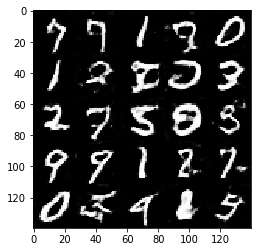

Epoch 2/2... Batch 410... Discriminator Loss: 1.2696... Generator Loss: 0.8007
Epoch 2/2... Batch 420... Discriminator Loss: 1.0991... Generator Loss: 1.1560
Epoch 2/2... Batch 430... Discriminator Loss: 1.0532... Generator Loss: 1.5592
Epoch 2/2... Batch 440... Discriminator Loss: 1.0377... Generator Loss: 1.0755
Epoch 2/2... Batch 450... Discriminator Loss: 1.2349... Generator Loss: 0.6477
Epoch 2/2... Batch 460... Discriminator Loss: 1.2731... Generator Loss: 2.4566


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.5674... Generator Loss: 1.9981
Epoch 1/1... Batch 20... Discriminator Loss: 0.4294... Generator Loss: 2.9288
Epoch 1/1... Batch 30... Discriminator Loss: 0.4523... Generator Loss: 2.5318
Epoch 1/1... Batch 40... Discriminator Loss: 0.4232... Generator Loss: 2.8636
Epoch 1/1... Batch 50... Discriminator Loss: 0.3955... Generator Loss: 3.2787
Epoch 1/1... Batch 60... Discriminator Loss: 0.3753... Generator Loss: 3.7664
Epoch 1/1... Batch 70... Discriminator Loss: 0.3700... Generator Loss: 4.1869
Epoch 1/1... Batch 80... Discriminator Loss: 0.3709... Generator Loss: 4.2042
Epoch 1/1... Batch 90... Discriminator Loss: 0.3593... Generator Loss: 5.1482
Epoch 1/1... Batch 100... Discriminator Loss: 0.3661... Generator Loss: 4.1038


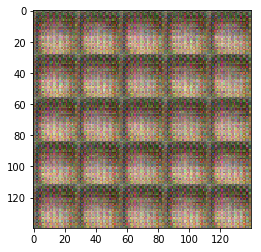

Epoch 1/1... Batch 110... Discriminator Loss: 0.4244... Generator Loss: 6.2688
Epoch 1/1... Batch 120... Discriminator Loss: 0.4417... Generator Loss: 3.8716
Epoch 1/1... Batch 130... Discriminator Loss: 0.3788... Generator Loss: 4.4670
Epoch 1/1... Batch 140... Discriminator Loss: 0.4210... Generator Loss: 2.8069
Epoch 1/1... Batch 150... Discriminator Loss: 0.3690... Generator Loss: 4.3071
Epoch 1/1... Batch 160... Discriminator Loss: 0.3587... Generator Loss: 4.8350
Epoch 1/1... Batch 170... Discriminator Loss: 0.3478... Generator Loss: 6.6724
Epoch 1/1... Batch 180... Discriminator Loss: 0.3747... Generator Loss: 4.2044
Epoch 1/1... Batch 190... Discriminator Loss: 0.4333... Generator Loss: 3.9152
Epoch 1/1... Batch 200... Discriminator Loss: 0.3726... Generator Loss: 4.0823


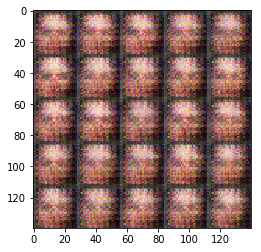

Epoch 1/1... Batch 210... Discriminator Loss: 0.3726... Generator Loss: 4.0152
Epoch 1/1... Batch 220... Discriminator Loss: 0.3885... Generator Loss: 3.3840
Epoch 1/1... Batch 230... Discriminator Loss: 0.3856... Generator Loss: 3.7602
Epoch 1/1... Batch 240... Discriminator Loss: 0.4717... Generator Loss: 2.3533
Epoch 1/1... Batch 250... Discriminator Loss: 0.3816... Generator Loss: 3.8660
Epoch 1/1... Batch 260... Discriminator Loss: 0.3824... Generator Loss: 3.9934
Epoch 1/1... Batch 270... Discriminator Loss: 0.3741... Generator Loss: 3.7333
Epoch 1/1... Batch 280... Discriminator Loss: 0.3929... Generator Loss: 3.2060
Epoch 1/1... Batch 290... Discriminator Loss: 0.3513... Generator Loss: 4.6260
Epoch 1/1... Batch 300... Discriminator Loss: 0.3460... Generator Loss: 5.4120


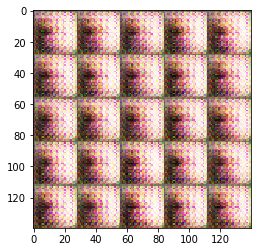

Epoch 1/1... Batch 310... Discriminator Loss: 0.3474... Generator Loss: 4.6380
Epoch 1/1... Batch 320... Discriminator Loss: 0.3791... Generator Loss: 3.4086
Epoch 1/1... Batch 330... Discriminator Loss: 0.3554... Generator Loss: 5.1827
Epoch 1/1... Batch 340... Discriminator Loss: 0.3671... Generator Loss: 3.6389
Epoch 1/1... Batch 350... Discriminator Loss: 0.3856... Generator Loss: 3.3631
Epoch 1/1... Batch 360... Discriminator Loss: 0.3834... Generator Loss: 3.2585
Epoch 1/1... Batch 370... Discriminator Loss: 0.4462... Generator Loss: 4.4750
Epoch 1/1... Batch 380... Discriminator Loss: 0.5732... Generator Loss: 4.5959
Epoch 1/1... Batch 390... Discriminator Loss: 0.4172... Generator Loss: 3.5789
Epoch 1/1... Batch 400... Discriminator Loss: 0.4142... Generator Loss: 3.2572


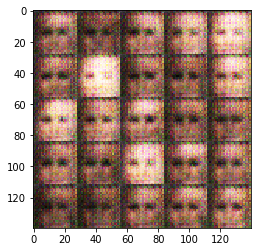

Epoch 1/1... Batch 410... Discriminator Loss: 0.4030... Generator Loss: 4.3495
Epoch 1/1... Batch 420... Discriminator Loss: 0.4436... Generator Loss: 2.9185
Epoch 1/1... Batch 430... Discriminator Loss: 0.3986... Generator Loss: 4.1113
Epoch 1/1... Batch 440... Discriminator Loss: 0.4777... Generator Loss: 4.8860
Epoch 1/1... Batch 450... Discriminator Loss: 0.3864... Generator Loss: 3.7521
Epoch 1/1... Batch 460... Discriminator Loss: 0.3945... Generator Loss: 4.3757
Epoch 1/1... Batch 470... Discriminator Loss: 0.4415... Generator Loss: 3.0668
Epoch 1/1... Batch 480... Discriminator Loss: 0.3886... Generator Loss: 4.1082
Epoch 1/1... Batch 490... Discriminator Loss: 0.3935... Generator Loss: 3.3580
Epoch 1/1... Batch 500... Discriminator Loss: 0.3902... Generator Loss: 4.1337


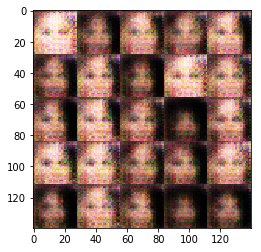

Epoch 1/1... Batch 510... Discriminator Loss: 0.4356... Generator Loss: 2.8938
Epoch 1/1... Batch 520... Discriminator Loss: 0.3921... Generator Loss: 3.7439
Epoch 1/1... Batch 530... Discriminator Loss: 0.4069... Generator Loss: 3.0216
Epoch 1/1... Batch 540... Discriminator Loss: 0.4150... Generator Loss: 3.7211
Epoch 1/1... Batch 550... Discriminator Loss: 0.3903... Generator Loss: 4.2048
Epoch 1/1... Batch 560... Discriminator Loss: 0.3923... Generator Loss: 3.7237
Epoch 1/1... Batch 570... Discriminator Loss: 0.4336... Generator Loss: 3.5319
Epoch 1/1... Batch 580... Discriminator Loss: 0.4489... Generator Loss: 2.9701
Epoch 1/1... Batch 590... Discriminator Loss: 0.3697... Generator Loss: 4.7043
Epoch 1/1... Batch 600... Discriminator Loss: 0.3880... Generator Loss: 4.8203


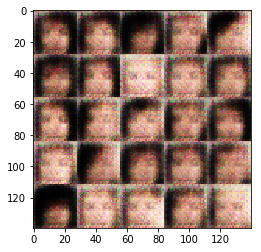

Epoch 1/1... Batch 610... Discriminator Loss: 0.3840... Generator Loss: 4.6131
Epoch 1/1... Batch 620... Discriminator Loss: 0.3979... Generator Loss: 3.7640
Epoch 1/1... Batch 630... Discriminator Loss: 0.4254... Generator Loss: 3.1053
Epoch 1/1... Batch 640... Discriminator Loss: 0.3966... Generator Loss: 3.9184
Epoch 1/1... Batch 650... Discriminator Loss: 0.3958... Generator Loss: 3.8840
Epoch 1/1... Batch 660... Discriminator Loss: 0.4019... Generator Loss: 3.5187
Epoch 1/1... Batch 670... Discriminator Loss: 0.6235... Generator Loss: 1.8629
Epoch 1/1... Batch 680... Discriminator Loss: 0.5034... Generator Loss: 2.5880
Epoch 1/1... Batch 690... Discriminator Loss: 0.3807... Generator Loss: 4.0961
Epoch 1/1... Batch 700... Discriminator Loss: 0.4976... Generator Loss: 4.7872


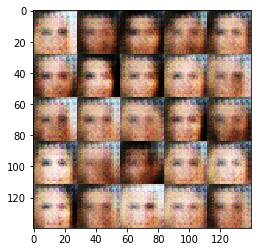

Epoch 1/1... Batch 710... Discriminator Loss: 0.4336... Generator Loss: 3.4855
Epoch 1/1... Batch 720... Discriminator Loss: 0.3895... Generator Loss: 4.0087
Epoch 1/1... Batch 730... Discriminator Loss: 0.4549... Generator Loss: 2.5420
Epoch 1/1... Batch 740... Discriminator Loss: 0.4088... Generator Loss: 3.6977
Epoch 1/1... Batch 750... Discriminator Loss: 0.3885... Generator Loss: 4.6872
Epoch 1/1... Batch 760... Discriminator Loss: 0.4232... Generator Loss: 4.1246
Epoch 1/1... Batch 770... Discriminator Loss: 0.3965... Generator Loss: 3.9568
Epoch 1/1... Batch 780... Discriminator Loss: 0.4296... Generator Loss: 4.1612
Epoch 1/1... Batch 790... Discriminator Loss: 0.5898... Generator Loss: 5.2534
Epoch 1/1... Batch 800... Discriminator Loss: 0.4002... Generator Loss: 3.4174


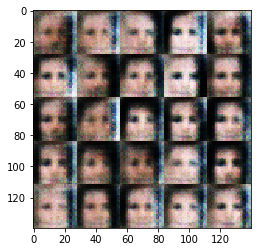

Epoch 1/1... Batch 810... Discriminator Loss: 0.3839... Generator Loss: 3.9764
Epoch 1/1... Batch 820... Discriminator Loss: 0.3920... Generator Loss: 4.1154
Epoch 1/1... Batch 830... Discriminator Loss: 0.4183... Generator Loss: 3.3325
Epoch 1/1... Batch 840... Discriminator Loss: 0.3775... Generator Loss: 4.0886
Epoch 1/1... Batch 850... Discriminator Loss: 0.5945... Generator Loss: 1.9611
Epoch 1/1... Batch 860... Discriminator Loss: 0.4248... Generator Loss: 4.6303
Epoch 1/1... Batch 870... Discriminator Loss: 0.4524... Generator Loss: 4.0268
Epoch 1/1... Batch 880... Discriminator Loss: 0.4213... Generator Loss: 3.2484
Epoch 1/1... Batch 890... Discriminator Loss: 0.4082... Generator Loss: 3.8816
Epoch 1/1... Batch 900... Discriminator Loss: 0.4355... Generator Loss: 5.9051


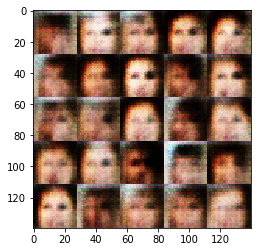

Epoch 1/1... Batch 910... Discriminator Loss: 0.3964... Generator Loss: 5.7682
Epoch 1/1... Batch 920... Discriminator Loss: 0.4071... Generator Loss: 3.5087
Epoch 1/1... Batch 930... Discriminator Loss: 0.5083... Generator Loss: 2.1548
Epoch 1/1... Batch 940... Discriminator Loss: 0.4167... Generator Loss: 3.3452
Epoch 1/1... Batch 950... Discriminator Loss: 0.4679... Generator Loss: 2.7683
Epoch 1/1... Batch 960... Discriminator Loss: 0.4401... Generator Loss: 3.5824
Epoch 1/1... Batch 970... Discriminator Loss: 0.4352... Generator Loss: 2.9258
Epoch 1/1... Batch 980... Discriminator Loss: 0.4624... Generator Loss: 3.7296
Epoch 1/1... Batch 990... Discriminator Loss: 0.4560... Generator Loss: 3.0118
Epoch 1/1... Batch 1000... Discriminator Loss: 0.4741... Generator Loss: 2.4854


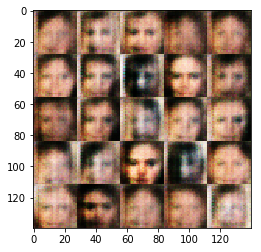

Epoch 1/1... Batch 1010... Discriminator Loss: 0.4449... Generator Loss: 2.9133
Epoch 1/1... Batch 1020... Discriminator Loss: 0.4142... Generator Loss: 3.5164
Epoch 1/1... Batch 1030... Discriminator Loss: 0.4477... Generator Loss: 6.3187
Epoch 1/1... Batch 1040... Discriminator Loss: 0.4405... Generator Loss: 2.9797
Epoch 1/1... Batch 1050... Discriminator Loss: 0.4844... Generator Loss: 2.5782
Epoch 1/1... Batch 1060... Discriminator Loss: 0.5742... Generator Loss: 2.0615
Epoch 1/1... Batch 1070... Discriminator Loss: 0.4078... Generator Loss: 3.8100
Epoch 1/1... Batch 1080... Discriminator Loss: 0.4407... Generator Loss: 2.7332
Epoch 1/1... Batch 1090... Discriminator Loss: 0.4261... Generator Loss: 3.0207
Epoch 1/1... Batch 1100... Discriminator Loss: 0.4492... Generator Loss: 3.1027


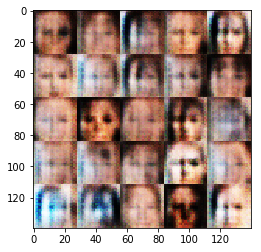

Epoch 1/1... Batch 1110... Discriminator Loss: 0.4319... Generator Loss: 3.0643
Epoch 1/1... Batch 1120... Discriminator Loss: 0.4137... Generator Loss: 3.6951
Epoch 1/1... Batch 1130... Discriminator Loss: 0.4485... Generator Loss: 2.8571
Epoch 1/1... Batch 1140... Discriminator Loss: 0.3892... Generator Loss: 3.8909
Epoch 1/1... Batch 1150... Discriminator Loss: 0.5827... Generator Loss: 1.8323
Epoch 1/1... Batch 1160... Discriminator Loss: 0.8806... Generator Loss: 5.0029
Epoch 1/1... Batch 1170... Discriminator Loss: 0.7961... Generator Loss: 1.4575
Epoch 1/1... Batch 1180... Discriminator Loss: 0.4318... Generator Loss: 3.7605
Epoch 1/1... Batch 1190... Discriminator Loss: 0.8021... Generator Loss: 1.3873
Epoch 1/1... Batch 1200... Discriminator Loss: 0.4893... Generator Loss: 2.4285


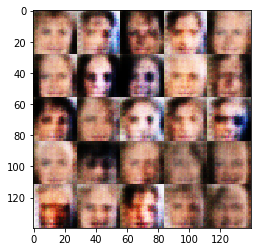

Epoch 1/1... Batch 1210... Discriminator Loss: 0.4325... Generator Loss: 3.0894
Epoch 1/1... Batch 1220... Discriminator Loss: 0.4580... Generator Loss: 2.8968
Epoch 1/1... Batch 1230... Discriminator Loss: 0.4387... Generator Loss: 3.7553
Epoch 1/1... Batch 1240... Discriminator Loss: 0.4400... Generator Loss: 3.3557
Epoch 1/1... Batch 1250... Discriminator Loss: 0.4523... Generator Loss: 3.1445
Epoch 1/1... Batch 1260... Discriminator Loss: 0.4352... Generator Loss: 3.0978
Epoch 1/1... Batch 1270... Discriminator Loss: 0.4466... Generator Loss: 3.0350
Epoch 1/1... Batch 1280... Discriminator Loss: 0.4555... Generator Loss: 4.0088
Epoch 1/1... Batch 1290... Discriminator Loss: 0.4762... Generator Loss: 2.7519
Epoch 1/1... Batch 1300... Discriminator Loss: 0.5033... Generator Loss: 2.3598


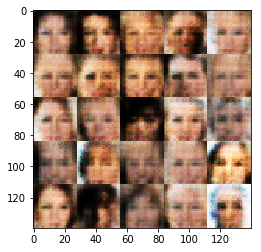

Epoch 1/1... Batch 1310... Discriminator Loss: 0.8023... Generator Loss: 5.2129
Epoch 1/1... Batch 1320... Discriminator Loss: 0.4534... Generator Loss: 3.0207
Epoch 1/1... Batch 1330... Discriminator Loss: 0.4672... Generator Loss: 2.6778
Epoch 1/1... Batch 1340... Discriminator Loss: 0.5110... Generator Loss: 2.3620
Epoch 1/1... Batch 1350... Discriminator Loss: 0.6551... Generator Loss: 1.8457
Epoch 1/1... Batch 1360... Discriminator Loss: 0.6051... Generator Loss: 1.9468
Epoch 1/1... Batch 1370... Discriminator Loss: 0.5329... Generator Loss: 2.2054
Epoch 1/1... Batch 1380... Discriminator Loss: 0.4774... Generator Loss: 2.7991
Epoch 1/1... Batch 1390... Discriminator Loss: 0.6592... Generator Loss: 4.7908
Epoch 1/1... Batch 1400... Discriminator Loss: 0.4768... Generator Loss: 2.6696


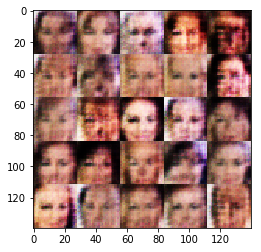

Epoch 1/1... Batch 1410... Discriminator Loss: 0.4943... Generator Loss: 2.8223
Epoch 1/1... Batch 1420... Discriminator Loss: 0.4478... Generator Loss: 2.8704
Epoch 1/1... Batch 1430... Discriminator Loss: 0.4440... Generator Loss: 3.7177
Epoch 1/1... Batch 1440... Discriminator Loss: 0.4596... Generator Loss: 2.9877
Epoch 1/1... Batch 1450... Discriminator Loss: 0.4712... Generator Loss: 2.7040
Epoch 1/1... Batch 1460... Discriminator Loss: 0.4635... Generator Loss: 2.9139
Epoch 1/1... Batch 1470... Discriminator Loss: 0.5261... Generator Loss: 2.1745
Epoch 1/1... Batch 1480... Discriminator Loss: 0.6130... Generator Loss: 3.5978
Epoch 1/1... Batch 1490... Discriminator Loss: 0.5241... Generator Loss: 3.8441
Epoch 1/1... Batch 1500... Discriminator Loss: 0.4905... Generator Loss: 2.4767


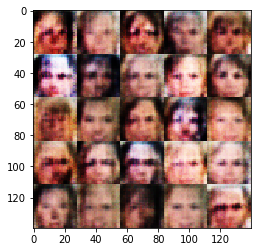

Epoch 1/1... Batch 1510... Discriminator Loss: 0.5458... Generator Loss: 2.1329
Epoch 1/1... Batch 1520... Discriminator Loss: 0.5799... Generator Loss: 1.9816
Epoch 1/1... Batch 1530... Discriminator Loss: 0.5415... Generator Loss: 2.1736
Epoch 1/1... Batch 1540... Discriminator Loss: 0.6097... Generator Loss: 1.9024
Epoch 1/1... Batch 1550... Discriminator Loss: 0.8072... Generator Loss: 5.1985
Epoch 1/1... Batch 1560... Discriminator Loss: 0.6728... Generator Loss: 1.4963
Epoch 1/1... Batch 1570... Discriminator Loss: 0.4561... Generator Loss: 3.3269
Epoch 1/1... Batch 1580... Discriminator Loss: 0.4748... Generator Loss: 2.5843
Epoch 1/1... Batch 1590... Discriminator Loss: 0.4922... Generator Loss: 2.7248
Epoch 1/1... Batch 1600... Discriminator Loss: 0.4791... Generator Loss: 2.6930


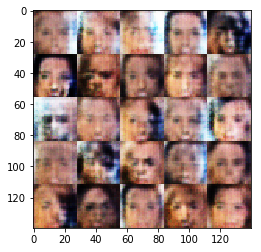

Epoch 1/1... Batch 1610... Discriminator Loss: 0.5030... Generator Loss: 2.5186
Epoch 1/1... Batch 1620... Discriminator Loss: 0.4294... Generator Loss: 3.0515
Epoch 1/1... Batch 1630... Discriminator Loss: 0.5172... Generator Loss: 2.4936
Epoch 1/1... Batch 1640... Discriminator Loss: 0.5825... Generator Loss: 3.3171
Epoch 1/1... Batch 1650... Discriminator Loss: 0.4458... Generator Loss: 3.3927
Epoch 1/1... Batch 1660... Discriminator Loss: 0.6358... Generator Loss: 1.7449
Epoch 1/1... Batch 1670... Discriminator Loss: 0.5146... Generator Loss: 2.9093
Epoch 1/1... Batch 1680... Discriminator Loss: 0.5023... Generator Loss: 3.3299
Epoch 1/1... Batch 1690... Discriminator Loss: 0.5050... Generator Loss: 2.9816
Epoch 1/1... Batch 1700... Discriminator Loss: 0.5672... Generator Loss: 2.8693


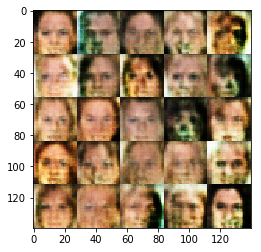

Epoch 1/1... Batch 1710... Discriminator Loss: 0.7980... Generator Loss: 1.2438
Epoch 1/1... Batch 1720... Discriminator Loss: 0.6283... Generator Loss: 1.7531
Epoch 1/1... Batch 1730... Discriminator Loss: 0.6840... Generator Loss: 3.8688
Epoch 1/1... Batch 1740... Discriminator Loss: 0.5258... Generator Loss: 2.3208
Epoch 1/1... Batch 1750... Discriminator Loss: 0.4988... Generator Loss: 2.8192
Epoch 1/1... Batch 1760... Discriminator Loss: 0.6003... Generator Loss: 1.8608
Epoch 1/1... Batch 1770... Discriminator Loss: 0.5712... Generator Loss: 1.9706
Epoch 1/1... Batch 1780... Discriminator Loss: 0.4634... Generator Loss: 2.8743
Epoch 1/1... Batch 1790... Discriminator Loss: 0.5835... Generator Loss: 2.0209
Epoch 1/1... Batch 1800... Discriminator Loss: 0.4844... Generator Loss: 2.7464


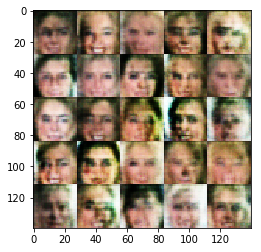

Epoch 1/1... Batch 1810... Discriminator Loss: 0.5423... Generator Loss: 2.1181
Epoch 1/1... Batch 1820... Discriminator Loss: 0.6277... Generator Loss: 3.8933
Epoch 1/1... Batch 1830... Discriminator Loss: 0.6465... Generator Loss: 1.7003
Epoch 1/1... Batch 1840... Discriminator Loss: 0.4881... Generator Loss: 2.3883
Epoch 1/1... Batch 1850... Discriminator Loss: 0.5954... Generator Loss: 3.7648
Epoch 1/1... Batch 1860... Discriminator Loss: 0.7205... Generator Loss: 1.4912
Epoch 1/1... Batch 1870... Discriminator Loss: 0.6000... Generator Loss: 3.5738
Epoch 1/1... Batch 1880... Discriminator Loss: 0.8069... Generator Loss: 1.3680
Epoch 1/1... Batch 1890... Discriminator Loss: 0.8133... Generator Loss: 3.8818
Epoch 1/1... Batch 1900... Discriminator Loss: 0.6063... Generator Loss: 3.2556


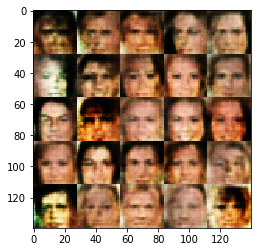

Epoch 1/1... Batch 1910... Discriminator Loss: 0.6064... Generator Loss: 3.2188
Epoch 1/1... Batch 1920... Discriminator Loss: 0.4793... Generator Loss: 3.5531
Epoch 1/1... Batch 1930... Discriminator Loss: 0.5596... Generator Loss: 1.9056
Epoch 1/1... Batch 1940... Discriminator Loss: 0.5185... Generator Loss: 2.5676
Epoch 1/1... Batch 1950... Discriminator Loss: 0.5969... Generator Loss: 2.0499
Epoch 1/1... Batch 1960... Discriminator Loss: 0.5536... Generator Loss: 2.4107
Epoch 1/1... Batch 1970... Discriminator Loss: 0.5599... Generator Loss: 3.3754
Epoch 1/1... Batch 1980... Discriminator Loss: 0.5605... Generator Loss: 1.9404
Epoch 1/1... Batch 1990... Discriminator Loss: 0.6540... Generator Loss: 1.6225
Epoch 1/1... Batch 2000... Discriminator Loss: 0.7088... Generator Loss: 3.5837


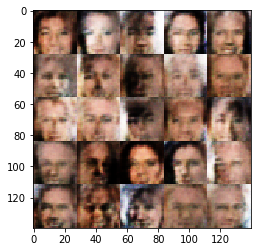

Epoch 1/1... Batch 2010... Discriminator Loss: 0.5467... Generator Loss: 2.3276
Epoch 1/1... Batch 2020... Discriminator Loss: 0.5797... Generator Loss: 1.8604
Epoch 1/1... Batch 2030... Discriminator Loss: 0.4108... Generator Loss: 3.6218
Epoch 1/1... Batch 2040... Discriminator Loss: 0.5442... Generator Loss: 2.5382
Epoch 1/1... Batch 2050... Discriminator Loss: 0.5613... Generator Loss: 1.8951
Epoch 1/1... Batch 2060... Discriminator Loss: 0.7157... Generator Loss: 2.8789
Epoch 1/1... Batch 2070... Discriminator Loss: 0.5735... Generator Loss: 1.9979
Epoch 1/1... Batch 2080... Discriminator Loss: 0.5508... Generator Loss: 2.0271
Epoch 1/1... Batch 2090... Discriminator Loss: 0.5103... Generator Loss: 2.2553
Epoch 1/1... Batch 2100... Discriminator Loss: 0.7028... Generator Loss: 3.7180


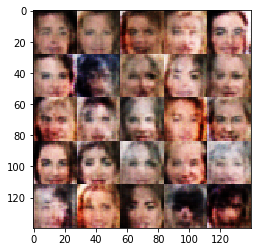

Epoch 1/1... Batch 2110... Discriminator Loss: 0.6872... Generator Loss: 1.5064
Epoch 1/1... Batch 2120... Discriminator Loss: 0.4980... Generator Loss: 3.2078
Epoch 1/1... Batch 2130... Discriminator Loss: 0.5379... Generator Loss: 2.2536
Epoch 1/1... Batch 2140... Discriminator Loss: 0.5361... Generator Loss: 2.5150
Epoch 1/1... Batch 2150... Discriminator Loss: 0.5195... Generator Loss: 2.2204
Epoch 1/1... Batch 2160... Discriminator Loss: 0.5918... Generator Loss: 1.9586
Epoch 1/1... Batch 2170... Discriminator Loss: 0.6003... Generator Loss: 2.4272
Epoch 1/1... Batch 2180... Discriminator Loss: 0.7631... Generator Loss: 1.2605
Epoch 1/1... Batch 2190... Discriminator Loss: 0.7171... Generator Loss: 1.6988
Epoch 1/1... Batch 2200... Discriminator Loss: 0.5523... Generator Loss: 2.3248


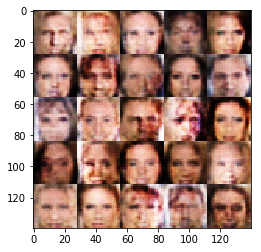

Epoch 1/1... Batch 2210... Discriminator Loss: 0.5728... Generator Loss: 1.9644
Epoch 1/1... Batch 2220... Discriminator Loss: 0.7460... Generator Loss: 1.3495
Epoch 1/1... Batch 2230... Discriminator Loss: 0.5696... Generator Loss: 2.1771
Epoch 1/1... Batch 2240... Discriminator Loss: 0.5679... Generator Loss: 1.9567
Epoch 1/1... Batch 2250... Discriminator Loss: 0.6330... Generator Loss: 1.7393
Epoch 1/1... Batch 2260... Discriminator Loss: 0.5226... Generator Loss: 3.0065
Epoch 1/1... Batch 2270... Discriminator Loss: 0.5617... Generator Loss: 2.0429
Epoch 1/1... Batch 2280... Discriminator Loss: 0.4510... Generator Loss: 2.8922
Epoch 1/1... Batch 2290... Discriminator Loss: 0.4788... Generator Loss: 2.9118
Epoch 1/1... Batch 2300... Discriminator Loss: 0.6082... Generator Loss: 1.7784


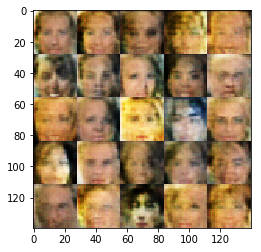

Epoch 1/1... Batch 2310... Discriminator Loss: 0.6570... Generator Loss: 3.0776
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7583... Generator Loss: 1.3041
Epoch 1/1... Batch 2330... Discriminator Loss: 0.7172... Generator Loss: 1.5277
Epoch 1/1... Batch 2340... Discriminator Loss: 0.7395... Generator Loss: 1.4642
Epoch 1/1... Batch 2350... Discriminator Loss: 0.5419... Generator Loss: 2.8228
Epoch 1/1... Batch 2360... Discriminator Loss: 0.6791... Generator Loss: 1.5094
Epoch 1/1... Batch 2370... Discriminator Loss: 0.6546... Generator Loss: 1.9307
Epoch 1/1... Batch 2380... Discriminator Loss: 0.4770... Generator Loss: 2.8652
Epoch 1/1... Batch 2390... Discriminator Loss: 0.5023... Generator Loss: 2.6462
Epoch 1/1... Batch 2400... Discriminator Loss: 0.5408... Generator Loss: 2.5218


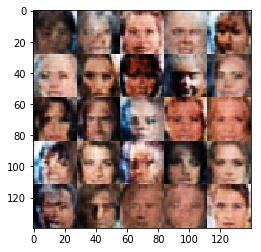

Epoch 1/1... Batch 2410... Discriminator Loss: 0.5104... Generator Loss: 2.4659
Epoch 1/1... Batch 2420... Discriminator Loss: 0.5429... Generator Loss: 2.0994
Epoch 1/1... Batch 2430... Discriminator Loss: 0.5809... Generator Loss: 2.4860
Epoch 1/1... Batch 2440... Discriminator Loss: 0.7360... Generator Loss: 1.3577
Epoch 1/1... Batch 2450... Discriminator Loss: 0.7318... Generator Loss: 1.4871
Epoch 1/1... Batch 2460... Discriminator Loss: 0.4804... Generator Loss: 2.5143
Epoch 1/1... Batch 2470... Discriminator Loss: 0.5708... Generator Loss: 2.6464
Epoch 1/1... Batch 2480... Discriminator Loss: 0.4646... Generator Loss: 3.5422
Epoch 1/1... Batch 2490... Discriminator Loss: 0.6236... Generator Loss: 2.7683
Epoch 1/1... Batch 2500... Discriminator Loss: 0.5173... Generator Loss: 3.2747


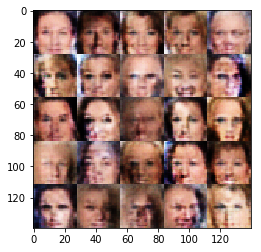

Epoch 1/1... Batch 2510... Discriminator Loss: 0.7334... Generator Loss: 2.7869
Epoch 1/1... Batch 2520... Discriminator Loss: 0.5969... Generator Loss: 2.2802
Epoch 1/1... Batch 2530... Discriminator Loss: 0.8862... Generator Loss: 1.1040
Epoch 1/1... Batch 2540... Discriminator Loss: 0.6761... Generator Loss: 1.5631
Epoch 1/1... Batch 2550... Discriminator Loss: 0.6476... Generator Loss: 1.7300
Epoch 1/1... Batch 2560... Discriminator Loss: 0.6088... Generator Loss: 1.8039
Epoch 1/1... Batch 2570... Discriminator Loss: 0.6742... Generator Loss: 1.5061
Epoch 1/1... Batch 2580... Discriminator Loss: 0.5788... Generator Loss: 2.1942
Epoch 1/1... Batch 2590... Discriminator Loss: 0.5337... Generator Loss: 2.7518
Epoch 1/1... Batch 2600... Discriminator Loss: 0.5513... Generator Loss: 2.3835


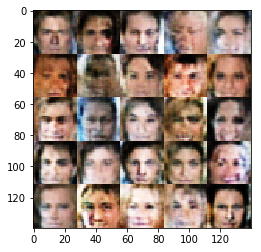

Epoch 1/1... Batch 2610... Discriminator Loss: 0.5577... Generator Loss: 2.2401
Epoch 1/1... Batch 2620... Discriminator Loss: 0.5381... Generator Loss: 2.1802
Epoch 1/1... Batch 2630... Discriminator Loss: 0.5681... Generator Loss: 2.0655
Epoch 1/1... Batch 2640... Discriminator Loss: 0.6493... Generator Loss: 2.1028
Epoch 1/1... Batch 2650... Discriminator Loss: 0.4946... Generator Loss: 2.5479
Epoch 1/1... Batch 2660... Discriminator Loss: 0.5249... Generator Loss: 2.1580
Epoch 1/1... Batch 2670... Discriminator Loss: 0.5501... Generator Loss: 2.8343
Epoch 1/1... Batch 2680... Discriminator Loss: 0.5243... Generator Loss: 2.3722
Epoch 1/1... Batch 2690... Discriminator Loss: 0.5282... Generator Loss: 2.2127
Epoch 1/1... Batch 2700... Discriminator Loss: 0.6091... Generator Loss: 2.0982


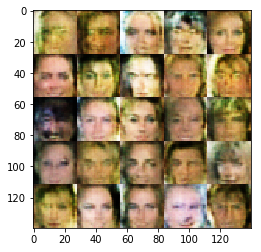

Epoch 1/1... Batch 2710... Discriminator Loss: 0.5070... Generator Loss: 2.3492
Epoch 1/1... Batch 2720... Discriminator Loss: 0.5902... Generator Loss: 1.8267
Epoch 1/1... Batch 2730... Discriminator Loss: 0.5380... Generator Loss: 3.7286
Epoch 1/1... Batch 2740... Discriminator Loss: 0.6356... Generator Loss: 1.6852
Epoch 1/1... Batch 2750... Discriminator Loss: 0.6881... Generator Loss: 1.5170
Epoch 1/1... Batch 2760... Discriminator Loss: 0.5140... Generator Loss: 2.1262
Epoch 1/1... Batch 2770... Discriminator Loss: 0.5968... Generator Loss: 1.7945
Epoch 1/1... Batch 2780... Discriminator Loss: 0.5830... Generator Loss: 1.9388
Epoch 1/1... Batch 2790... Discriminator Loss: 0.8378... Generator Loss: 1.1677
Epoch 1/1... Batch 2800... Discriminator Loss: 0.5144... Generator Loss: 2.5733


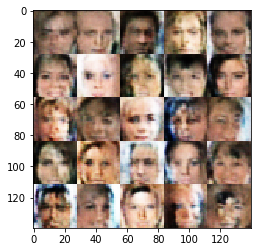

Epoch 1/1... Batch 2810... Discriminator Loss: 0.6631... Generator Loss: 1.6857
Epoch 1/1... Batch 2820... Discriminator Loss: 0.6191... Generator Loss: 2.6888
Epoch 1/1... Batch 2830... Discriminator Loss: 0.5898... Generator Loss: 2.9122
Epoch 1/1... Batch 2840... Discriminator Loss: 0.6188... Generator Loss: 3.1967
Epoch 1/1... Batch 2850... Discriminator Loss: 0.5404... Generator Loss: 2.6890
Epoch 1/1... Batch 2860... Discriminator Loss: 0.5356... Generator Loss: 2.3439
Epoch 1/1... Batch 2870... Discriminator Loss: 0.6976... Generator Loss: 1.4896
Epoch 1/1... Batch 2880... Discriminator Loss: 0.8048... Generator Loss: 2.7976
Epoch 1/1... Batch 2890... Discriminator Loss: 0.6028... Generator Loss: 2.1807
Epoch 1/1... Batch 2900... Discriminator Loss: 0.5661... Generator Loss: 2.0106


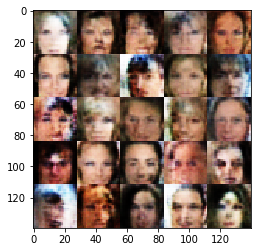

Epoch 1/1... Batch 2910... Discriminator Loss: 0.5678... Generator Loss: 1.8592
Epoch 1/1... Batch 2920... Discriminator Loss: 0.6534... Generator Loss: 1.5895
Epoch 1/1... Batch 2930... Discriminator Loss: 0.5994... Generator Loss: 1.9084
Epoch 1/1... Batch 2940... Discriminator Loss: 0.5476... Generator Loss: 2.5490
Epoch 1/1... Batch 2950... Discriminator Loss: 0.4811... Generator Loss: 2.6416
Epoch 1/1... Batch 2960... Discriminator Loss: 0.7992... Generator Loss: 1.1898
Epoch 1/1... Batch 2970... Discriminator Loss: 0.5261... Generator Loss: 2.4434
Epoch 1/1... Batch 2980... Discriminator Loss: 0.5972... Generator Loss: 2.6612
Epoch 1/1... Batch 2990... Discriminator Loss: 0.5266... Generator Loss: 2.1581
Epoch 1/1... Batch 3000... Discriminator Loss: 0.5527... Generator Loss: 2.2061


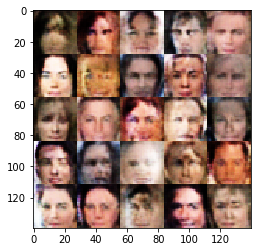

Epoch 1/1... Batch 3010... Discriminator Loss: 0.5857... Generator Loss: 2.1614
Epoch 1/1... Batch 3020... Discriminator Loss: 0.6107... Generator Loss: 1.7722
Epoch 1/1... Batch 3030... Discriminator Loss: 0.6300... Generator Loss: 1.7274
Epoch 1/1... Batch 3040... Discriminator Loss: 0.5118... Generator Loss: 2.5031
Epoch 1/1... Batch 3050... Discriminator Loss: 0.5985... Generator Loss: 3.0038
Epoch 1/1... Batch 3060... Discriminator Loss: 0.5977... Generator Loss: 1.9233
Epoch 1/1... Batch 3070... Discriminator Loss: 0.7304... Generator Loss: 1.3973
Epoch 1/1... Batch 3080... Discriminator Loss: 0.6943... Generator Loss: 1.5144
Epoch 1/1... Batch 3090... Discriminator Loss: 0.6492... Generator Loss: 1.6437
Epoch 1/1... Batch 3100... Discriminator Loss: 0.5701... Generator Loss: 2.0991


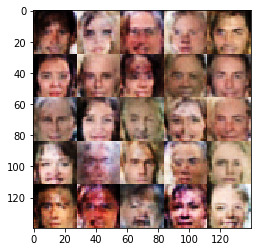

Epoch 1/1... Batch 3110... Discriminator Loss: 0.8116... Generator Loss: 1.2443
Epoch 1/1... Batch 3120... Discriminator Loss: 0.5048... Generator Loss: 2.7308
Epoch 1/1... Batch 3130... Discriminator Loss: 0.6390... Generator Loss: 1.7721
Epoch 1/1... Batch 3140... Discriminator Loss: 0.5140... Generator Loss: 2.3460
Epoch 1/1... Batch 3150... Discriminator Loss: 0.6244... Generator Loss: 2.5807
Epoch 1/1... Batch 3160... Discriminator Loss: 0.6054... Generator Loss: 1.8434


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.